In [1]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack, Column
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime


from astropy.io import fits

import corner
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb

from scipy import stats
from scipy.optimize import curve_fit
import scipy.optimize as opt
from multiprocessing import Pool

from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import glob
import lightkurve as lk


from lightkurve.correctors import RegressionCorrector
from lightkurve.correctors import DesignMatrix
from astropy.timeseries import LombScargle

import stella
from tqdm import tqdm_notebook
import os, sys

from stella.download_nn_set import DownloadSets

import celerite2
from celerite2 import terms
from scipy.optimize import minimize

from scipy import integrate
import astropy.units as u

2023-09-18 15:38:40.754511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
OUT_DIR='/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting Started/Results/'

cnn = stella.ConvNN(output_dir=OUT_DIR)

ds = DownloadSets()
ds.download_models()

MODELS=ds.models

Can only use stella.ConvNN.predict().
Models have already been downloaded to ~/.stella/models


In [18]:
search = lk.search_lightcurve(target='tic220473309', mission='TESS', exptime=120, author='SPOC')

lcs=[]

for i in range(len(search)):
    lc = search[i].download().PDCSAP_FLUX
    lc=lc[~np.isnan(lc.flux.value)]
#    lc.plot();

    lcs.append(lc)

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/283197433.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/283197433.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/283197433.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/283197433.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[i].download().PDCSAP_FLUX
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/283197433.py:6: Ligh

In [19]:
search

SearchResult containing 31 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 02 2018   SPOC     120   220473309      0.0
  1 TESS Sector 03 2018   SPOC     120   220473309      0.0
...            ...  ...    ...     ...         ...      ...
 29 TESS Sector 67 2023   SPOC     120   220473309      0.0
 30 TESS Sector 68 2023   SPOC     120   220473309      0.0
Length = 31 rows

In [4]:
def Stella_Flare_Preds(lc):
    cnn = stella.ConvNN(output_dir=OUT_DIR)
    
    preds = np.zeros((len(MODELS),len(lc)))

    for j, model in enumerate(MODELS):
        cnn.predict(modelname=model,
                    times=lc.time.value,
                    fluxes=lc.flux.value,
                    errs=lc.flux_err.value)
        preds[j] = cnn.predictions[0]

    avg_pred = np.nanmedian(preds, axis=0)
    
    fig=plt.figure()
    plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, label=('Sector'+str(lc.sector)))
    plt.xlabel('Time [BJD-2457000]')
    plt.ylabel('Normalized Flux')
    plt.colorbar(label='Probability')
    plt.legend()
    plt.subplots_adjust(right=1.5)
    plt.show()
    plt.close(fig)

    return avg_pred

In [5]:
def find_flares(lc, pred, threshhold=0.3, min_flare_points=3):
    x = lc.time.value
    y = lc.flux.value

    yerr= lc.flux_err.value
    
    bool_above_thresh= pred > threshhold


    where_flips = [y-x for x, y in zip(np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0], np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][1:])]
    where_flips

    where_flips.insert(0, np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][0])
    where_flips.append(len(bool_above_thresh)-np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][-1])

    falses_lens=where_flips[::2]

    trues_lens=where_flips[1::2]
    
    new_flare_boolean=[]

    for i in range(len(falses_lens)-1):
        if falses_lens[i] > 20:
            new_flare_boolean.append([False for i in range(falses_lens[i])])
            new_flare_boolean.append([True for i in range(trues_lens[i])])
        else:
            new_flare_boolean.append([True for i in range(falses_lens[i])])
            new_flare_boolean.append([True for i in range(trues_lens[i])])

    new_flare_boolean.append([False for i in range(falses_lens[-1])])

    new_bool=np.array([item for sublist in new_flare_boolean for item in sublist])
    

    new_where_flips = [y-x for x, y in zip(np.where(new_bool[:-1] != new_bool[1:])[0], np.where(new_bool[:-1] != new_bool[1:])[0][1:])]
    new_where_flips

    new_where_flips.insert(0, np.where(new_bool[:-1] != new_bool[1:])[0][0])
    new_where_flips.append(len(new_bool)-np.where(new_bool[:-1] != new_bool[1:])[0][-1])

    new_falses_lens=new_where_flips[::2]

    new_trues_lens=new_where_flips[1::2]
    
    start_and_stops=[x for x, y in zip(np.where(new_bool[:-1] != new_bool[1:])[0], np.where(new_bool[:-1] != new_bool[1:])[0][1:])]

    starts=start_and_stops[::2]
    stops=start_and_stops[1::2]
    stops.append(starts[-1]+1)
    
    #Only selecting where the length of the flare is greater than 3 data points

    v2_flare_boolean=[]

    for i in range(len(new_falses_lens)-1):
        if new_trues_lens[i] > min_flare_points:
            v2_flare_boolean.append([False for i in range(new_falses_lens[i])])
            v2_flare_boolean.append([True for i in range(new_trues_lens[i])])
        else:
            v2_flare_boolean.append([False for i in range(new_falses_lens[i])])
            v2_flare_boolean.append([False for i in range(new_trues_lens[i])])

    v2_flare_boolean.append([False for i in range(new_falses_lens[-1])])

    v2_bool=np.array([item for sublist in v2_flare_boolean for item in sublist])
    
    v2_start_and_stops=[x for x, y in zip(np.where(v2_bool[:-1] != v2_bool[1:])[0], np.where(v2_bool[:-1] != v2_bool[1:])[0][1:])]

    v2_starts=v2_start_and_stops[::2][:-1]
    v2_stops=v2_start_and_stops[1::2]
    
    return v2_starts, v2_stops, v2_bool

In [6]:
def fit_GP(lc, flare_bool):
    x = lc.time.value
    y = lc.flux.value

    yerr= lc.flux_err.value
    
    masked_x=x[~flare_bool]
    masked_y=y[~flare_bool]
    masked_yerr=yerr[~flare_bool]
    
        # Quasi-periodic term
    term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

    # Non-periodic component
    term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
    kernel = term1 + term2

    # Setup the GP
    gp = celerite2.GaussianProcess(kernel, mean=0.0)
    gp.compute(x, yerr=yerr)
    
    # Setup the GP
    gp = celerite2.GaussianProcess(kernel, mean=0.0)
    gp.compute(np.array(masked_x), yerr=np.array(masked_yerr))

    def set_params(params, gp):
        gp.mean = params[0]
        theta = np.exp(params[1:])
        gp.kernel = terms.SHOTerm(
            sigma=theta[0], rho=theta[1], tau=theta[2]
        ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
        gp.compute(np.array(masked_x), diag=masked_yerr**2 + theta[5], quiet=True)
        return gp


    def neg_log_like(params, gp):
        gp = set_params(params, gp)
        return -gp.log_likelihood(np.array(masked_y))


    initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
    soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
    opt_gp = set_params(soln.x, gp)
    soln

    mu=np.zeros(len(x))

    def plot_prediction(gp):
        plt.plot(np.array(masked_x), np.array(masked_y), "k", lw=1.5, alpha=0.3, label="data")
        #plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

        if gp:
            mu, variance = gp.predict(np.array(masked_y), t=x, return_var=True)
            sigma = np.sqrt(variance)
            plt.plot(x, mu, label="prediction")
            plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)

        plt.xlabel("x")
        plt.ylabel("y")
        #plt.xlim(0, 10)
        #plt.ylim(-2.5, 2.5)
        plt.legend()
        return mu

    plt.title("initial prediction")
    mu = plot_prediction(opt_gp)
    
    return mu


In [7]:
from FFD.FFD import FFD, FlareKernel

In [8]:
def equivelant_durations(lc, flare_starts, flare_stops, gaussian_process):
    EDs=np.zeros(len(flare_starts))

    for i in range(len(flare_starts)):

        flare_ind=range(flare_starts[i], flare_stops[i])


        #subtracting off the GP:

        use_fluxes=(lc.flux.value[flare_ind]-gaussian_process[flare_ind])/np.median(lc.flux.value)

        flare_energy=integrate.trapezoid(y=use_fluxes, x=lc.time.value[flare_ind])


        EDs[i]=flare_energy

    return EDs

In [9]:
def flare_freqency(lc, flare_starts, flare_stops, equiv_durations):
    flare_durations=np.zeros(len(flare_starts))

    for i in range(len(flare_starts)):
        flare_ind=range(flare_starts[i], flare_stops[i])

        flare_durations[i]= lc.time.value[flare_ind][-1] - lc.time.value[flare_ind][0]

    x,y,xe,ye = FFD(equiv_durations*u.day.to(u.second), dur=flare_durations, Lum=30,
                    fluxerr=np.median(np.array(lc.flux_err.value))/np.median(np.array(lc.flux.value)))

    im, xx, yy = FlareKernel(x,y,xe,ye)
    
    return x, y, xe, ye


In [10]:
def putting_it_all_together(lc):
    preds = Stella_Flare_Preds(lc)
    
    flare_starts, flare_stops, flare_bool = find_flares(lc, preds)
    
    GP_model = fit_GP(lc, flare_bool)
    
    EDs = equivelant_durations(lc, flare_starts, flare_stops, GP_model)
    
    Flare_energies, Flare_Rates, Flare_energies_err, Flare_Rates_err = flare_freqency(lc, flare_starts, flare_stops, EDs)
    
    return Flare_energies, Flare_Rates, Flare_energies_err, Flare_Rates_err, flare_starts, flare_stops, EDs

Can only use stella.ConvNN.predict().


2023-09-18 16:02:25.322117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 4ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


100%|███████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


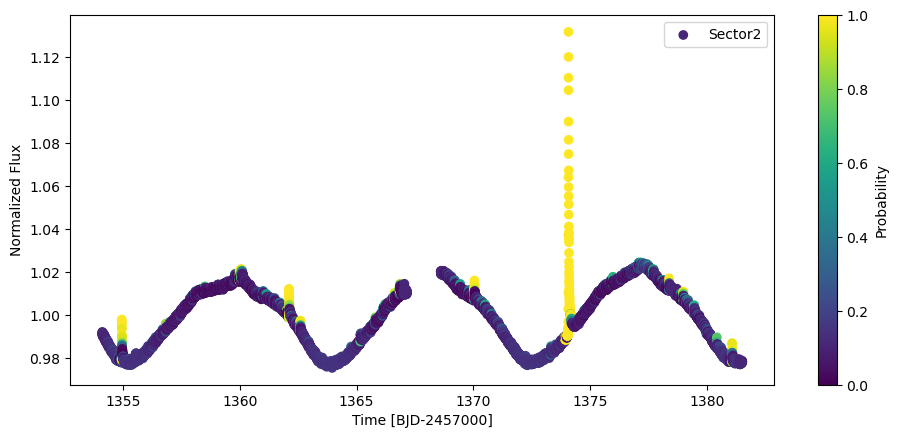

/Users/Tobin/Dropbox/Stellar_Flares_Project/TIC_220473309/FFD/FFD.py:55: RuntimeWarning: invalid value encountered in log10
  ffd_x = np.log10(ED[ss]) + Lum


Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

405/405 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


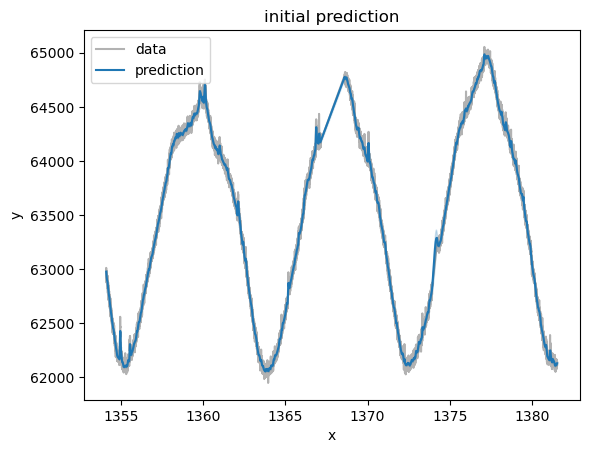

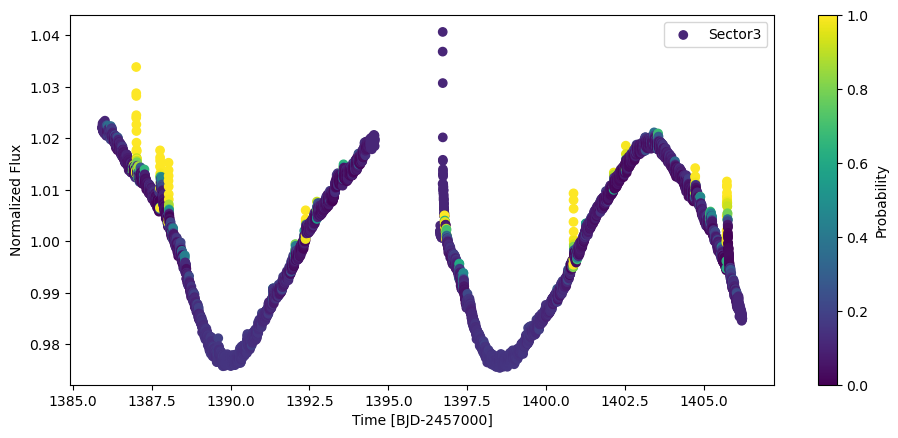

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 3s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

460/460 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


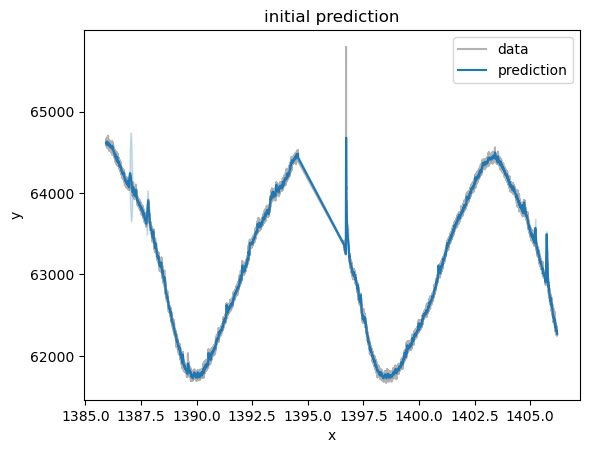

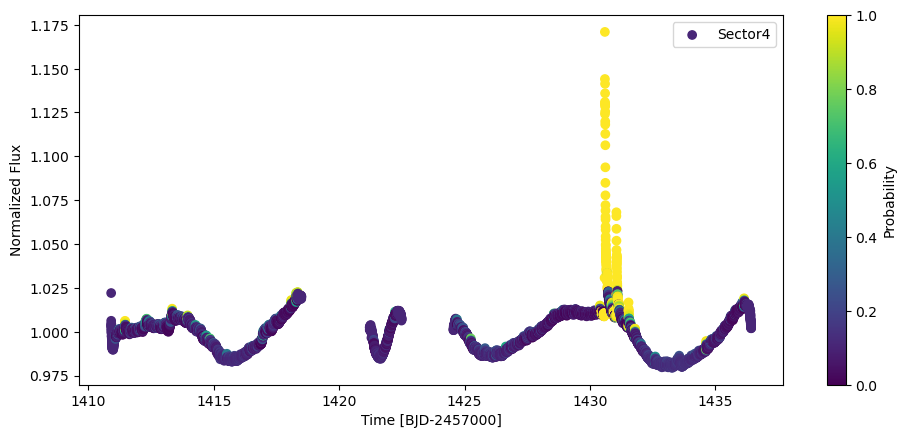

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

532/532 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


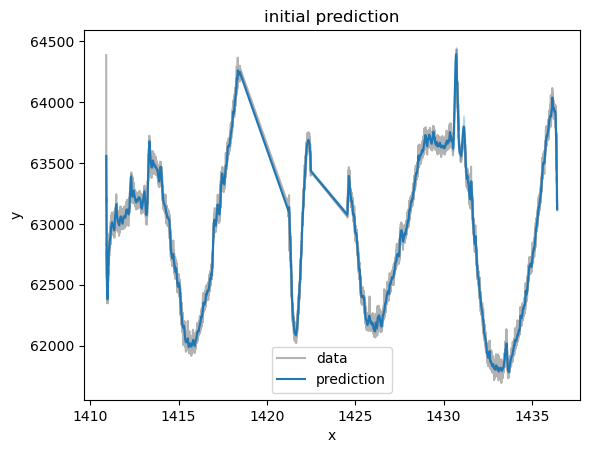

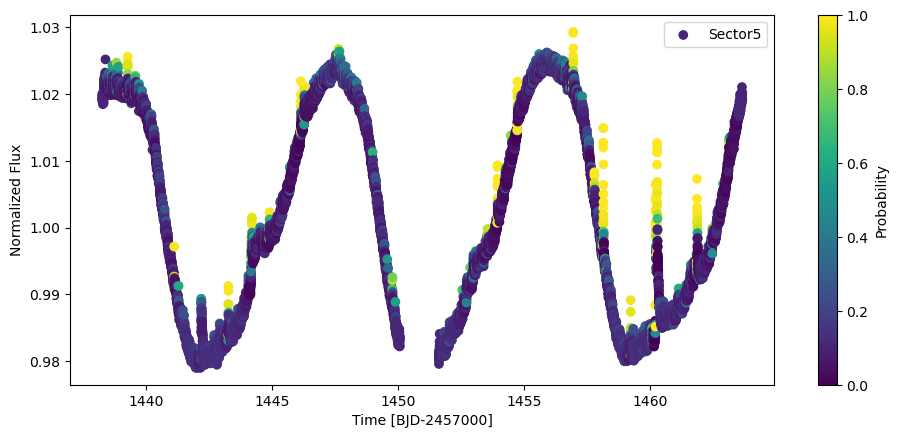

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

454/454 [==============================] - 3s 2ms/step


100%|███████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]


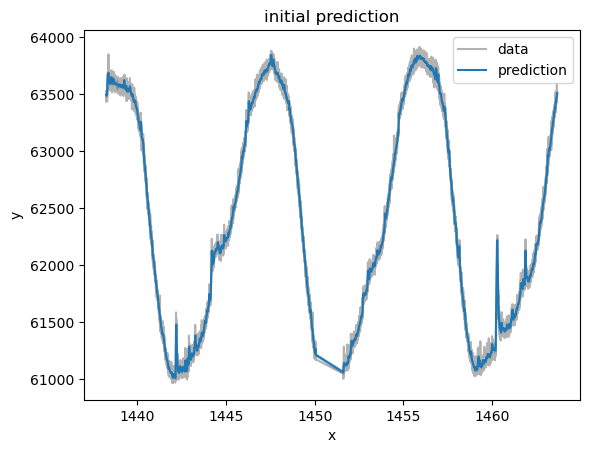

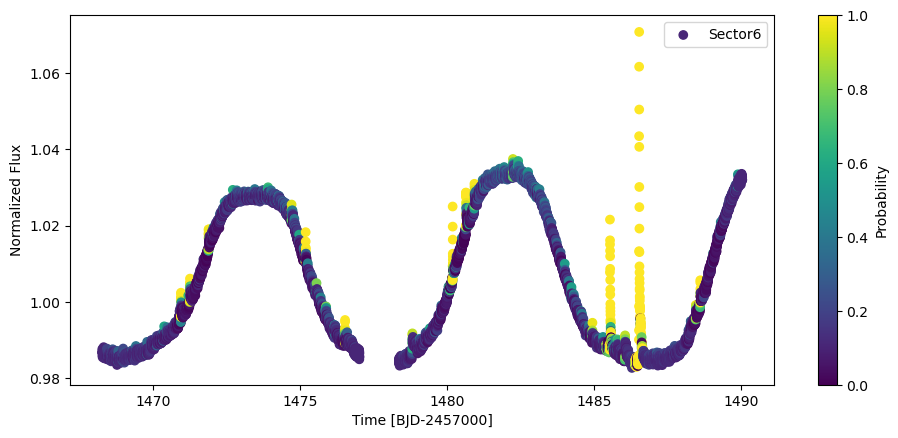

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

506/506 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


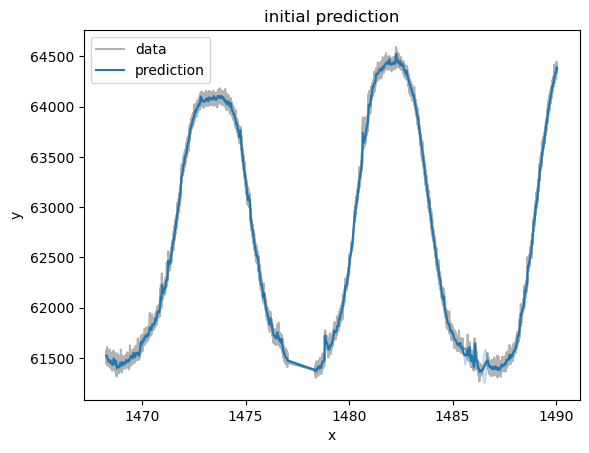

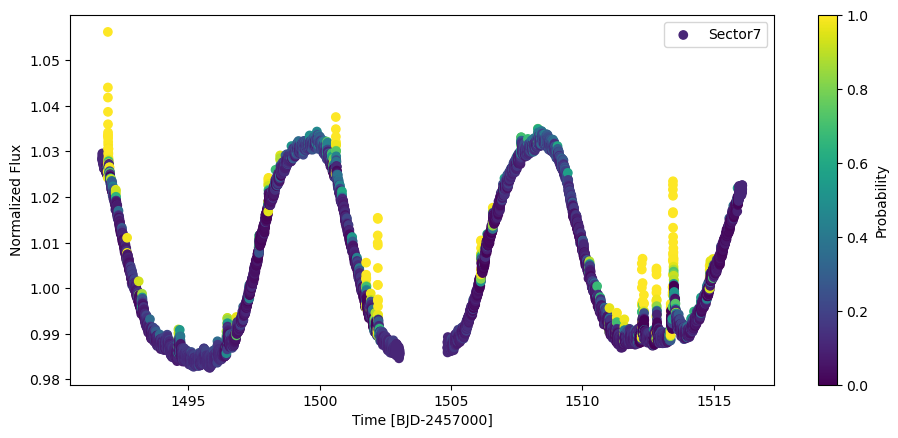

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

401/401 [==============================] - 1s 3ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


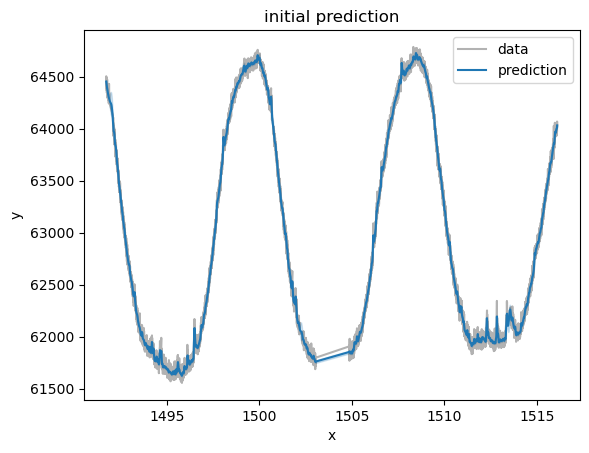

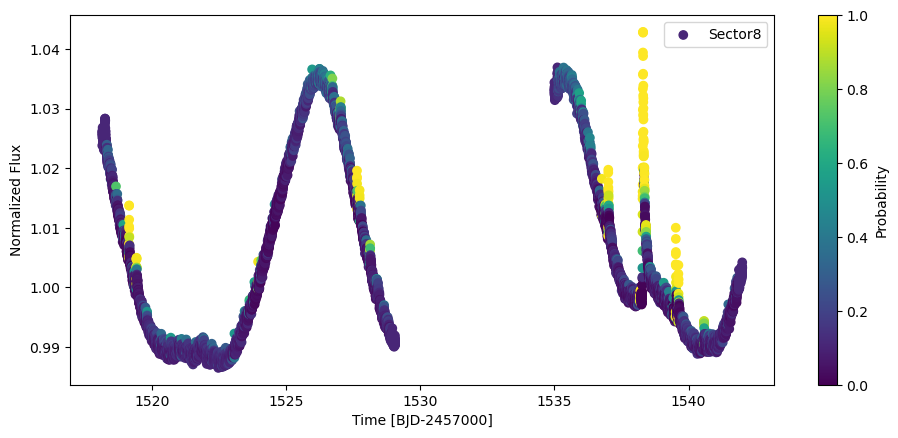

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 2s 4ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

477/477 [==============================] - 3s 5ms/step


100%|███████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


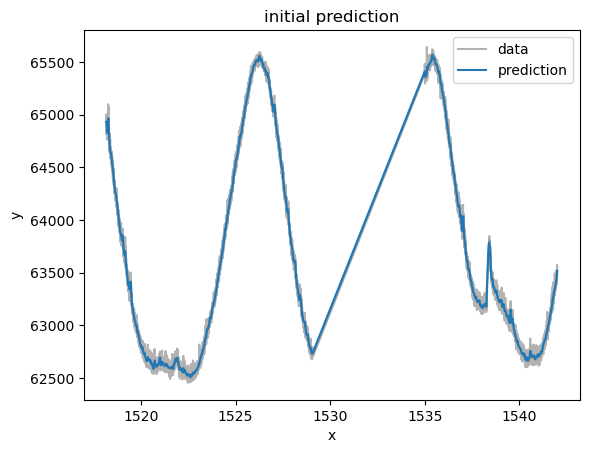

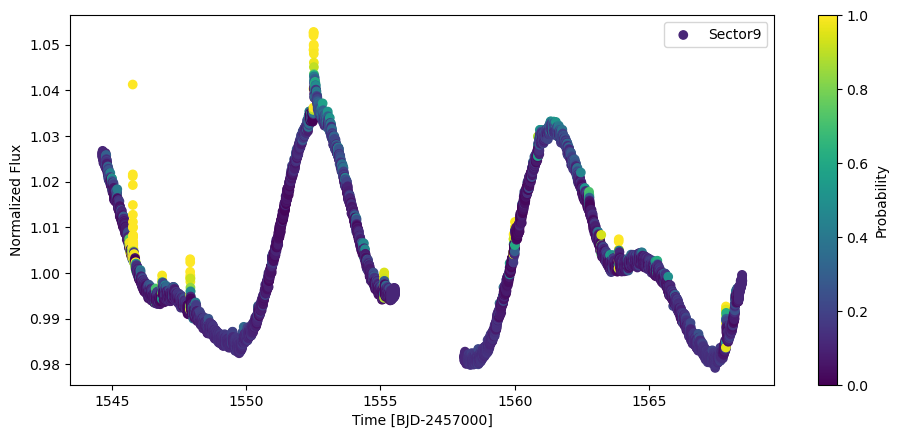

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

432/432 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


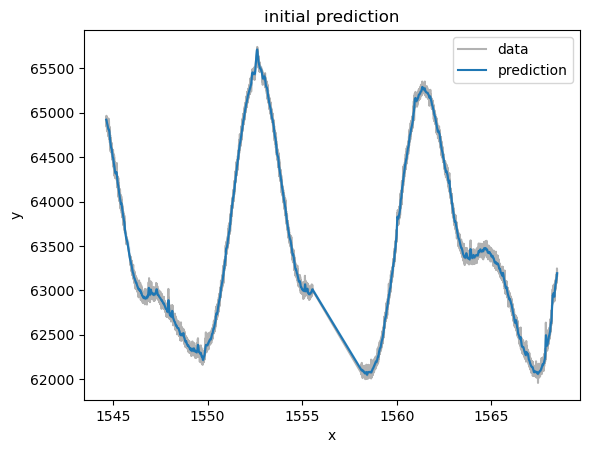

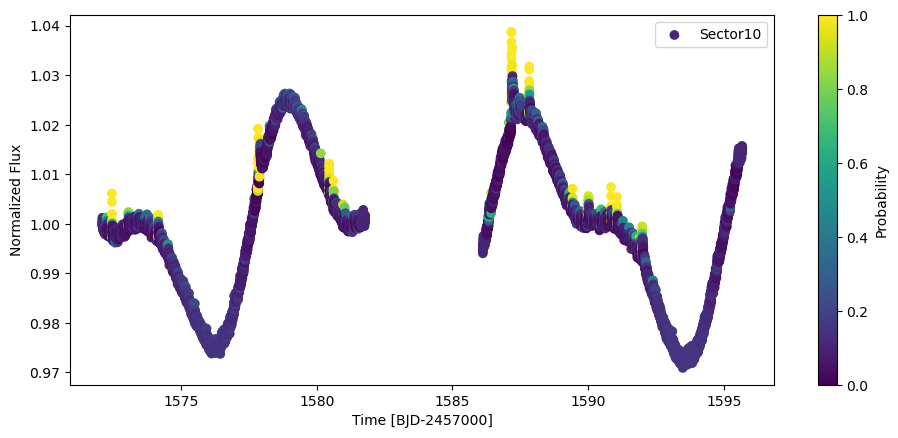

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 3s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

439/439 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


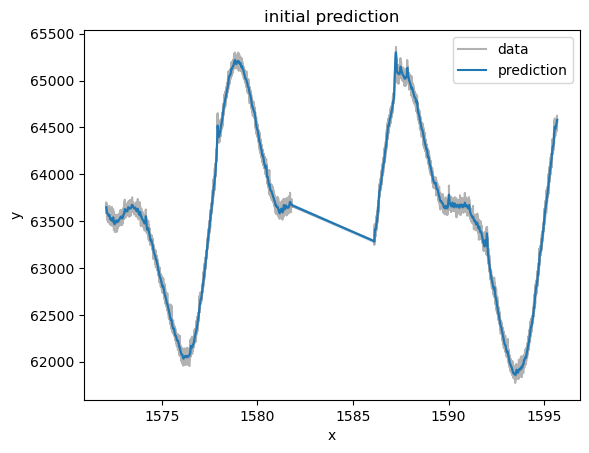

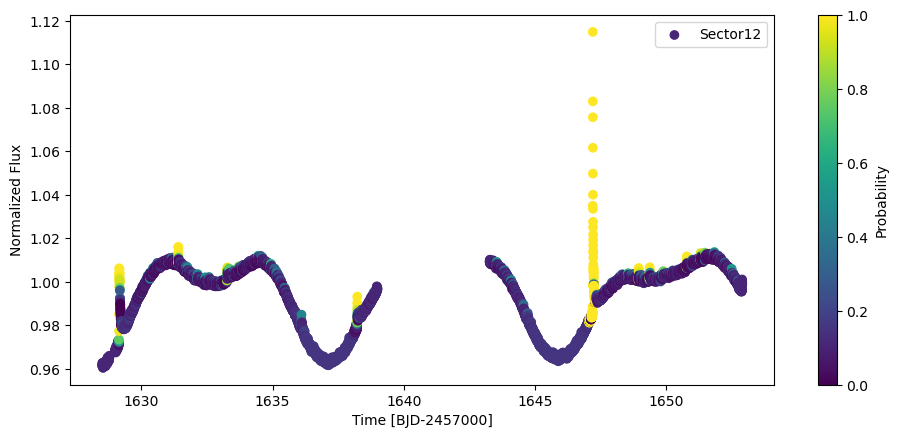

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

597/597 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


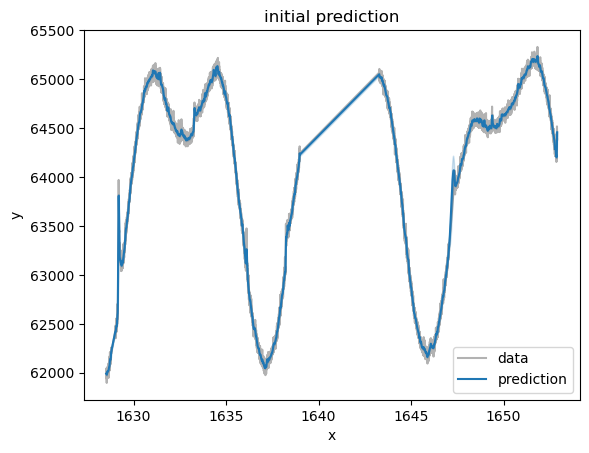

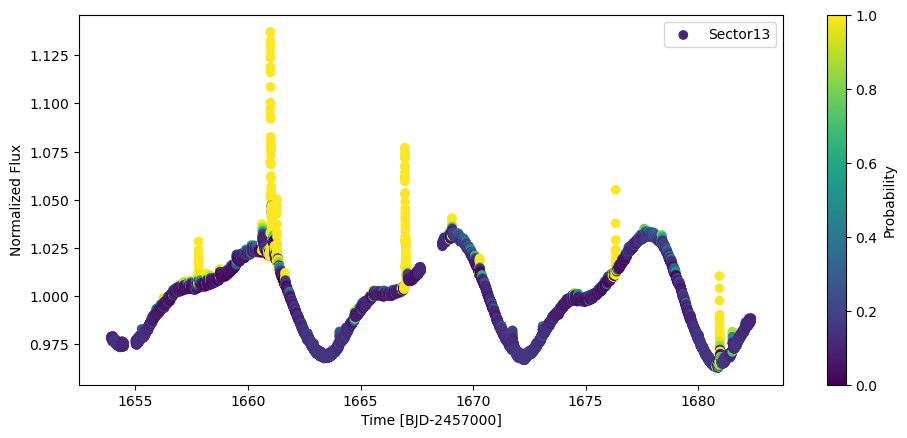

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


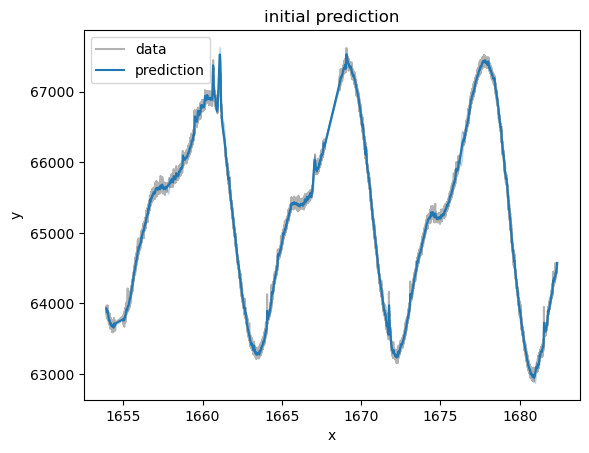

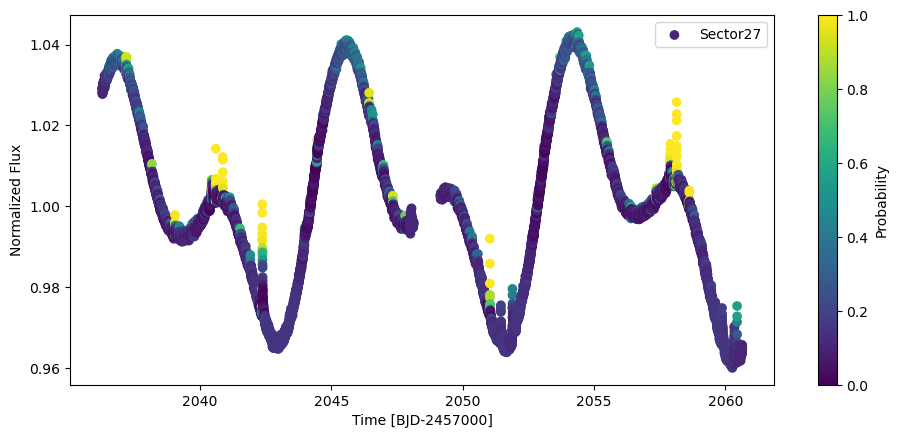

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

474/474 [==============================] - 1s 3ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


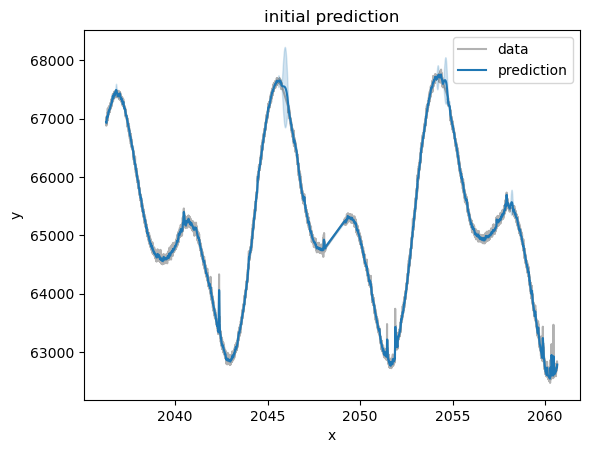

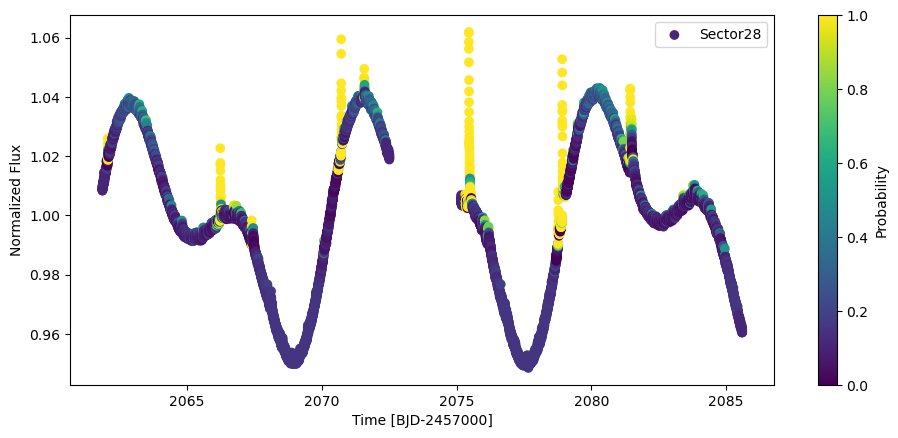

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

467/467 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


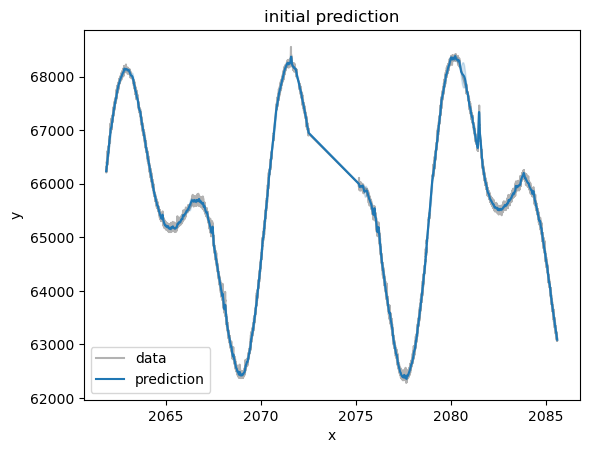

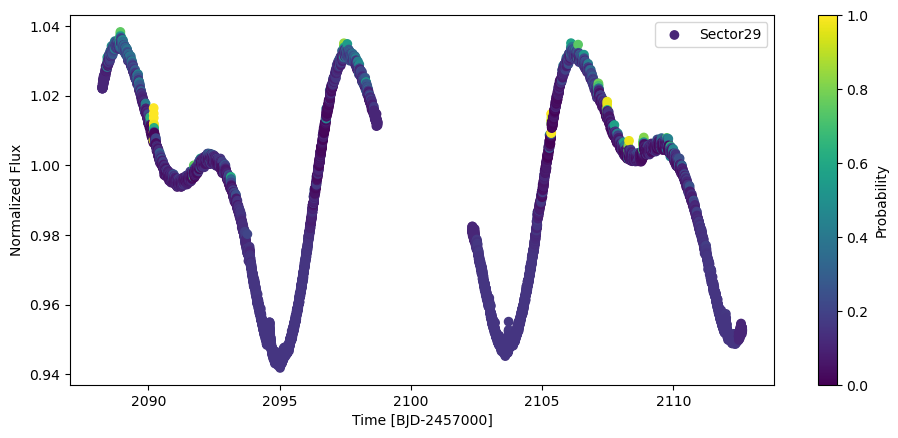

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 5s 5ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


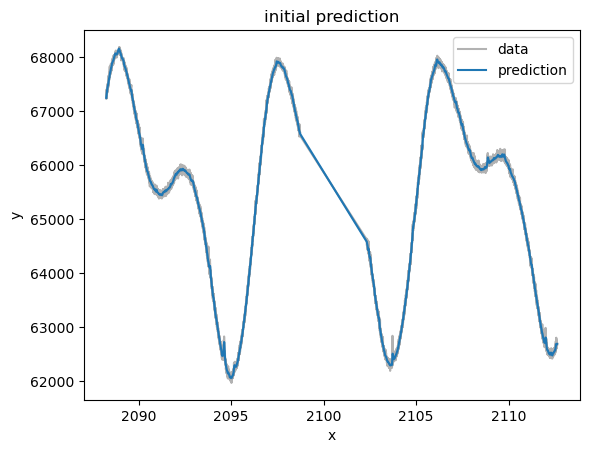

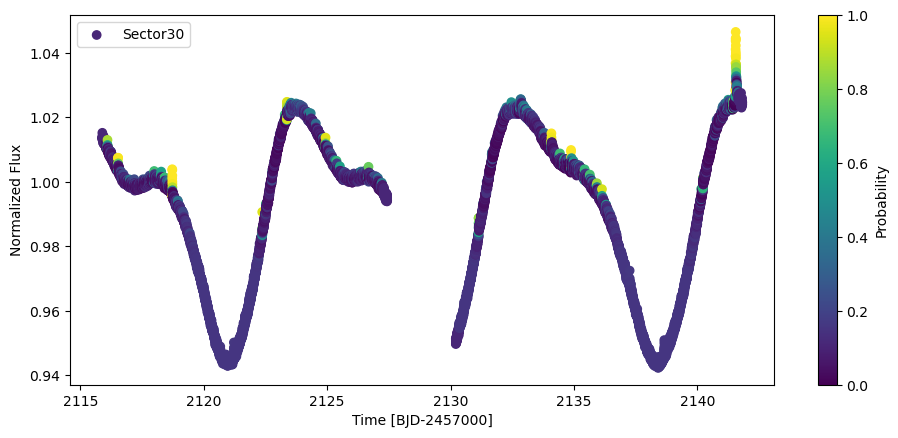

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


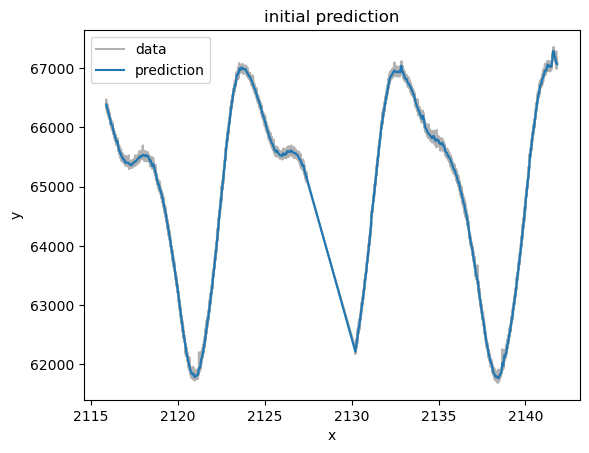

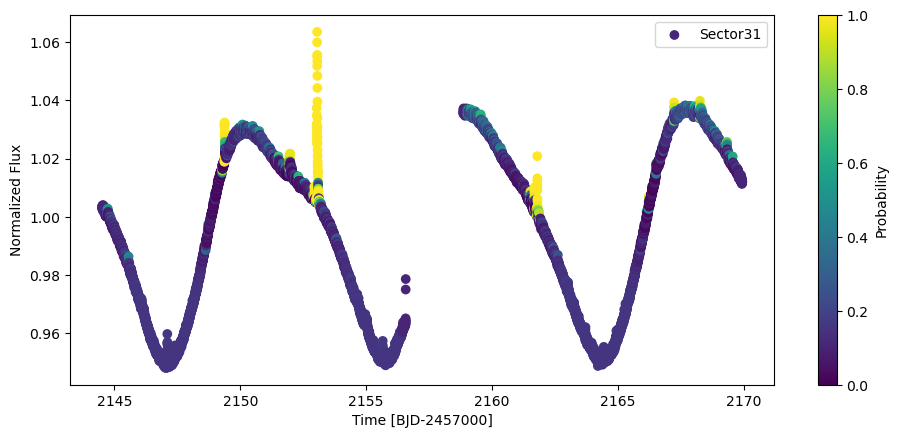

/Users/Tobin/opt/anaconda3/envs/Jim/lib/python3.10/site-packages/celerite2/numpy.py:108: RuntimeWarning: overflow encountered in square
  return np.sum(alpha ** 2 / self._d)
/Users/Tobin/opt/anaconda3/envs/Jim/lib/python3.10/site-packages/celerite2/numpy.py:108: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(alpha ** 2 / self._d)
/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/3848297693.py:28: RuntimeWarning: overflow encountered in exp
  theta = np.exp(params[1:])
/Users/Tobin/opt/anaconda3/envs/Jim/lib/python3.10/site-packages/celerite2/terms.py:659: RuntimeWarning: invalid value encountered in multiply
  0.5
/Users/Tobin/opt/anaconda3/envs/Jim/lib/python3.10/site-packages/celerite2/numpy.py:83: RuntimeWarning: invalid value encountered in log
  self._log_det = np.sum(np.log(self._d))


OverflowError: (34, 'Result too large')

In [23]:
sector_specific_energies=[]
sector_specific_rates=[]
energy_errors=[]
rate_errors=[]

flare_starts_list=[]
flare_stops_list=[]

EDs_list=[]

for i in range(len(lcs)):
    x, y, xe, ye, flare_starts, flare_stops, EDs = putting_it_all_together(lcs[i])
    
    sector_specific_energies.append(x)
    sector_specific_rates.append(y)
    energy_errors.append(xe)
    rate_errors.append(ye)
    
    flare_starts_list.append(flare_starts)
    flare_stops_list.append(flare_stops)
    EDs_list.append(EDs)


In [35]:
sectors[16:]

[32, 33, 34, 35, 36, 37, 38, 39, 62, 63, 64, 65, 66, 67, 68]

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

547/547 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]


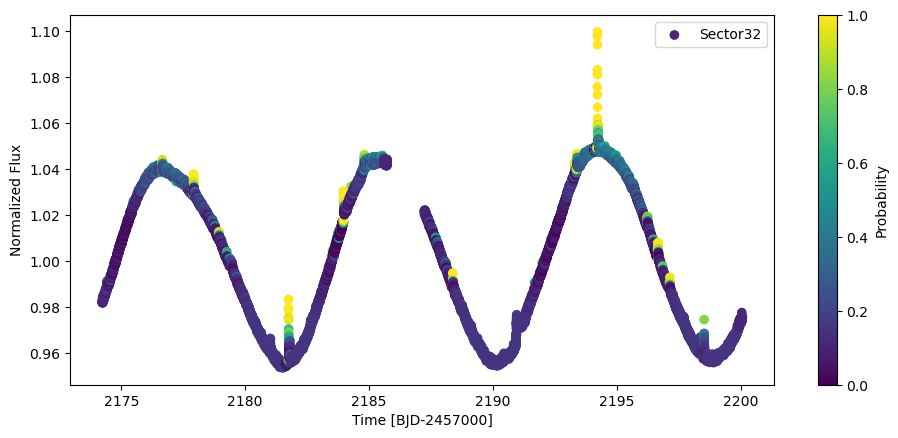

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

546/546 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


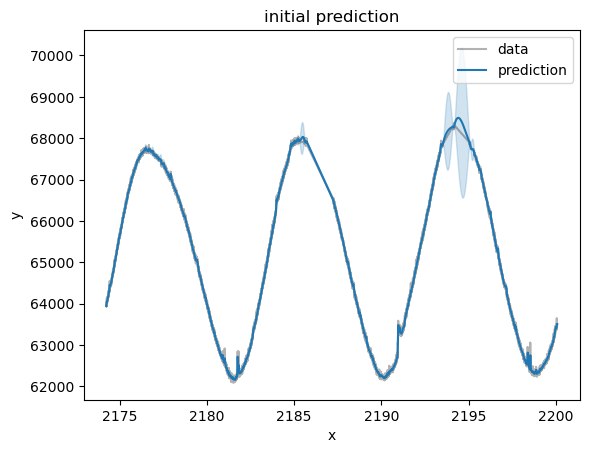

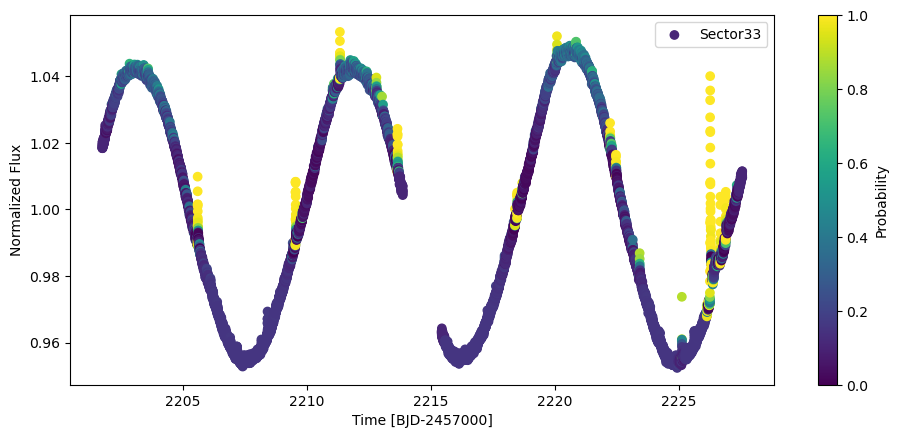

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 3s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

525/525 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


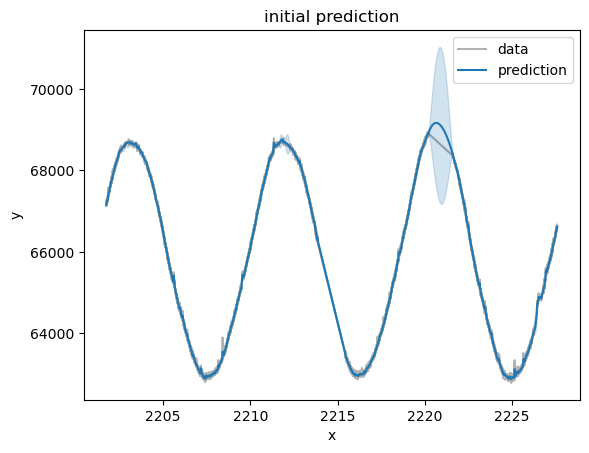

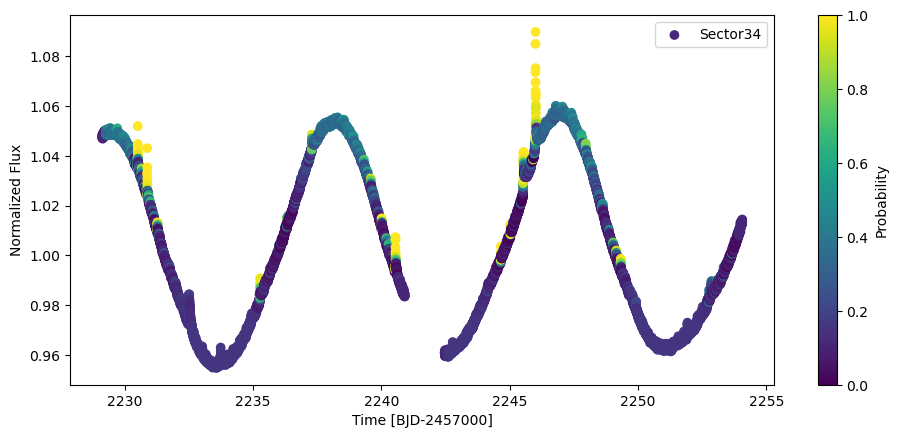

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

424/424 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


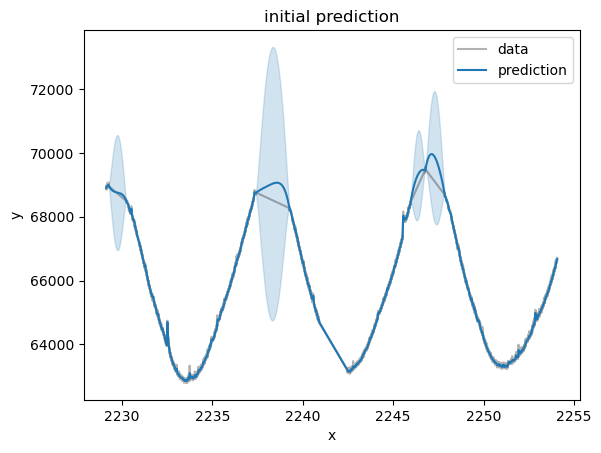

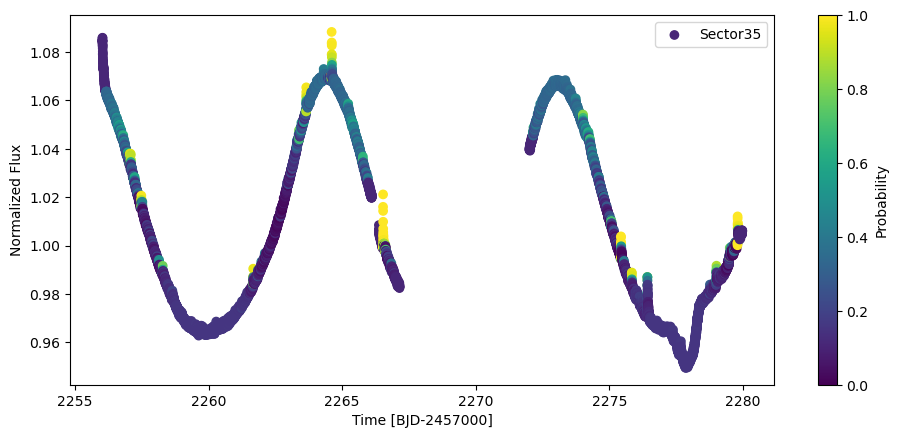

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

465/465 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


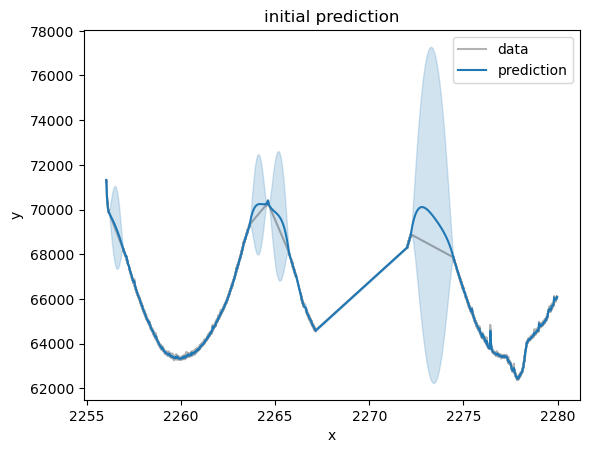

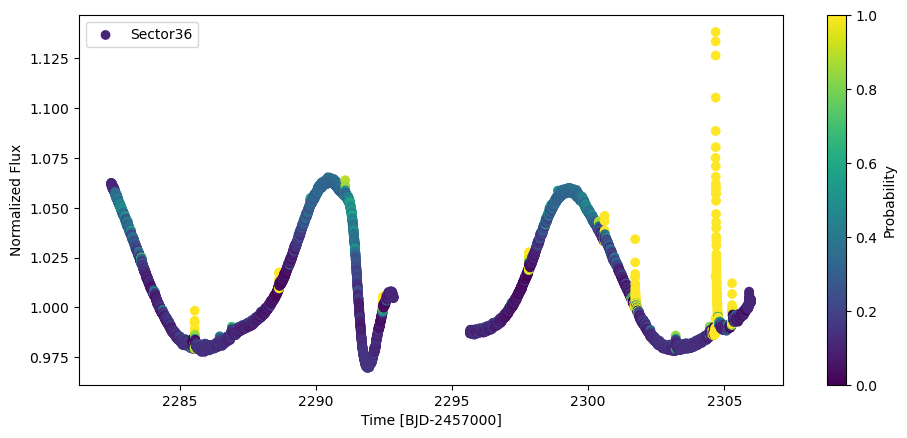

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

443/443 [==============================] - 2s 3ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


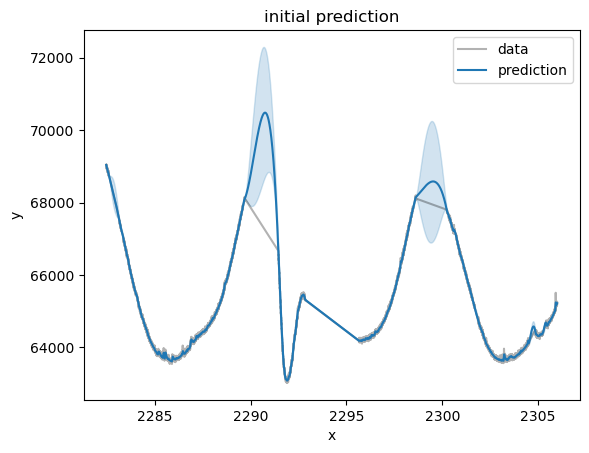

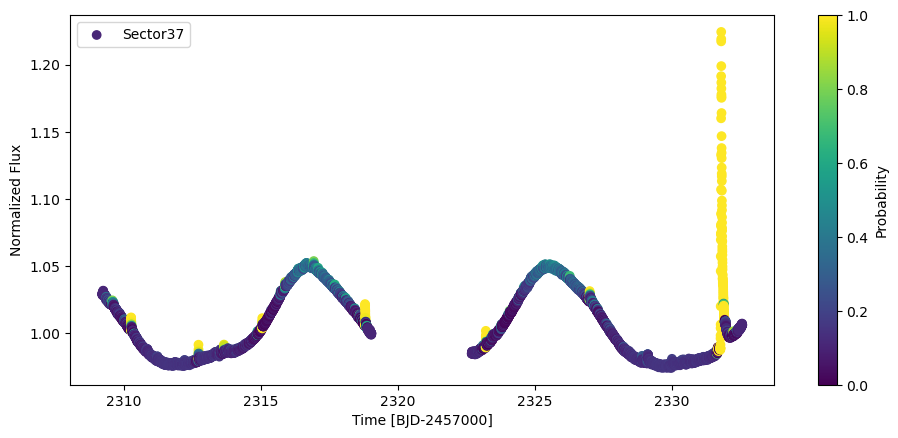

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

473/473 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


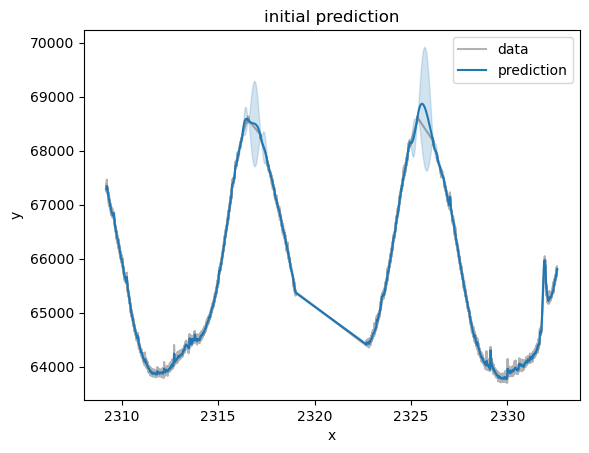

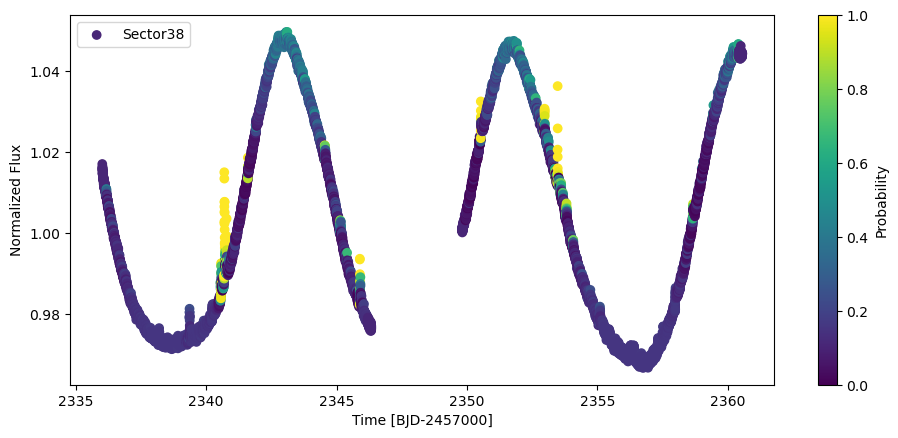

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

605/605 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


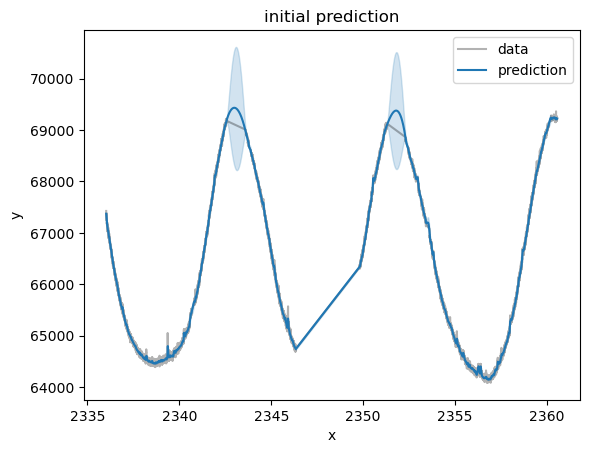

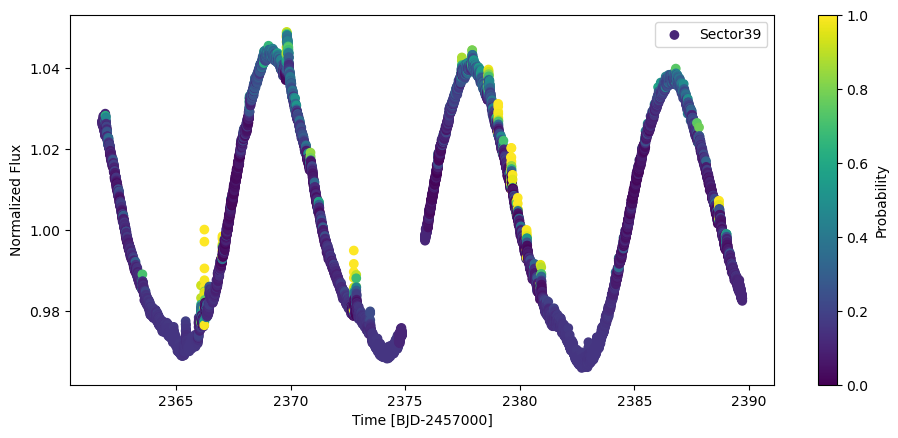

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

488/488 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]


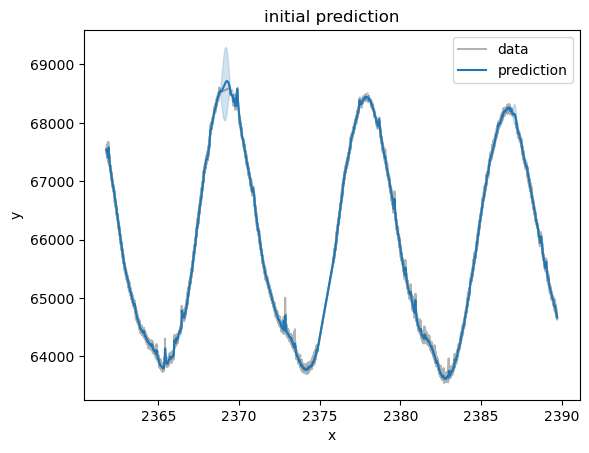

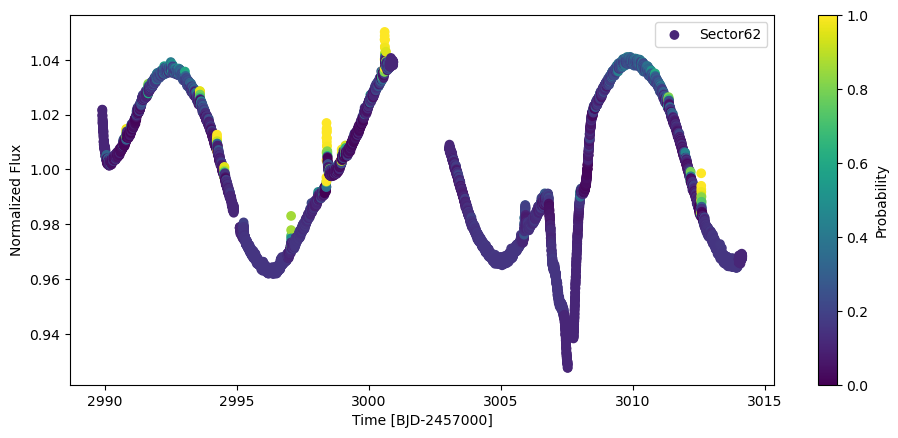

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

564/564 [==============================] - 2s 3ms/step


100%|███████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


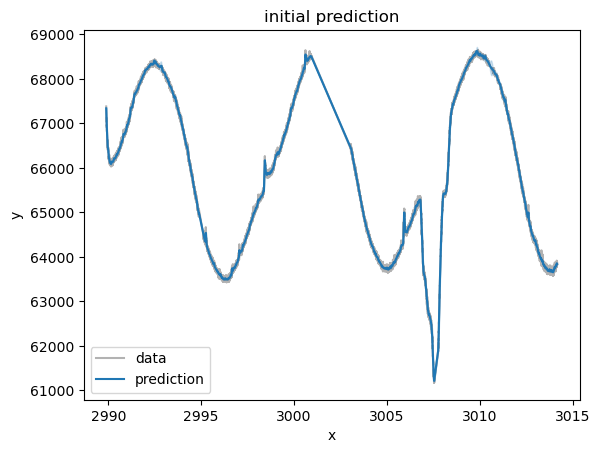

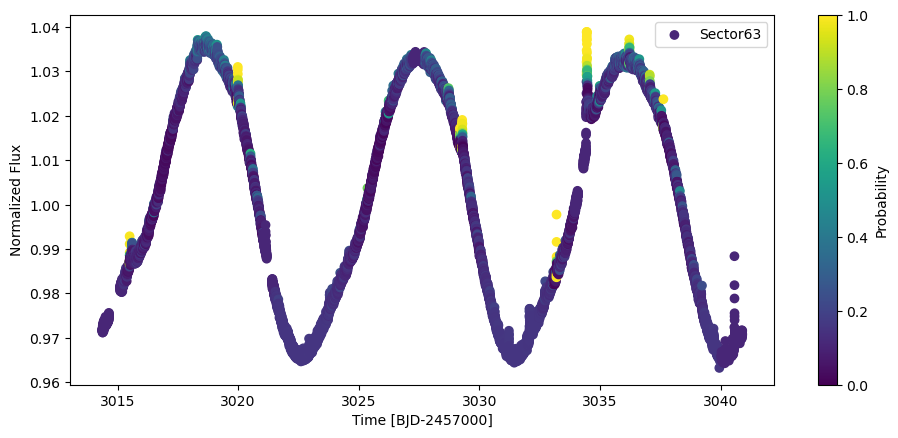

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

590/590 [==============================] - 2s 3ms/step


100%|███████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


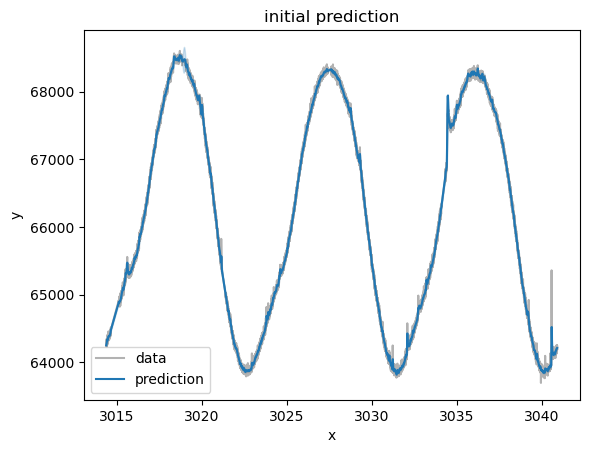

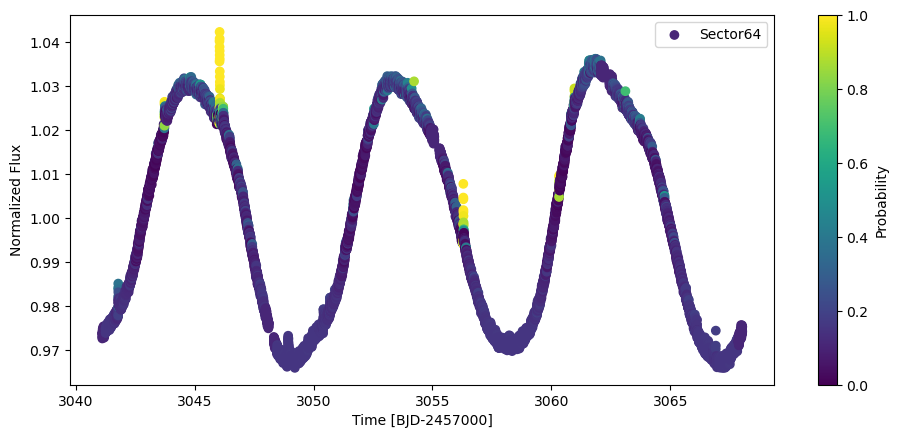

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 3s 5ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 2s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

534/534 [==============================] - 2s 3ms/step


100%|███████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


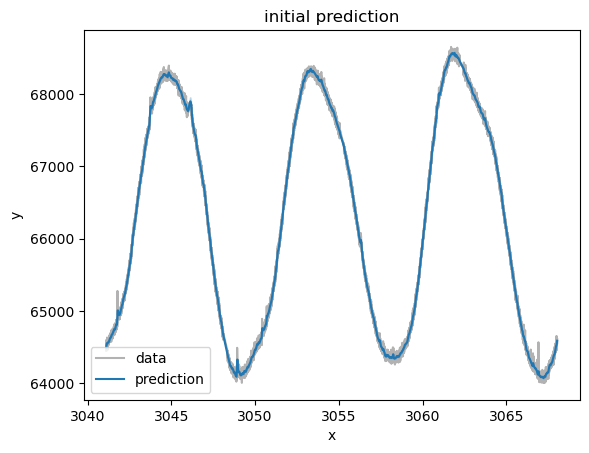

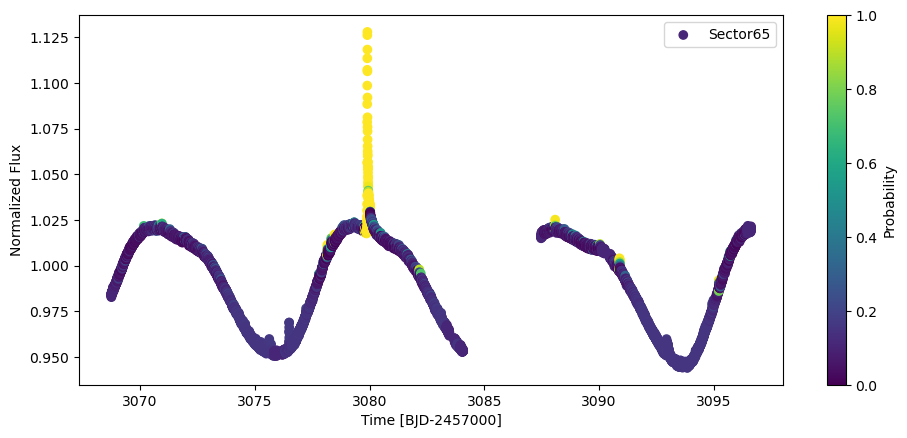

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 4s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

409/409 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


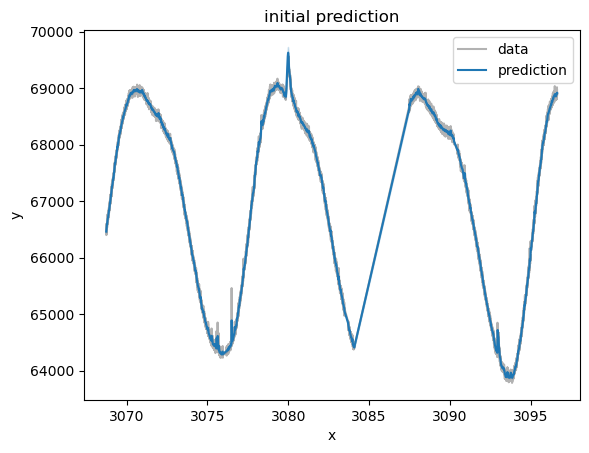

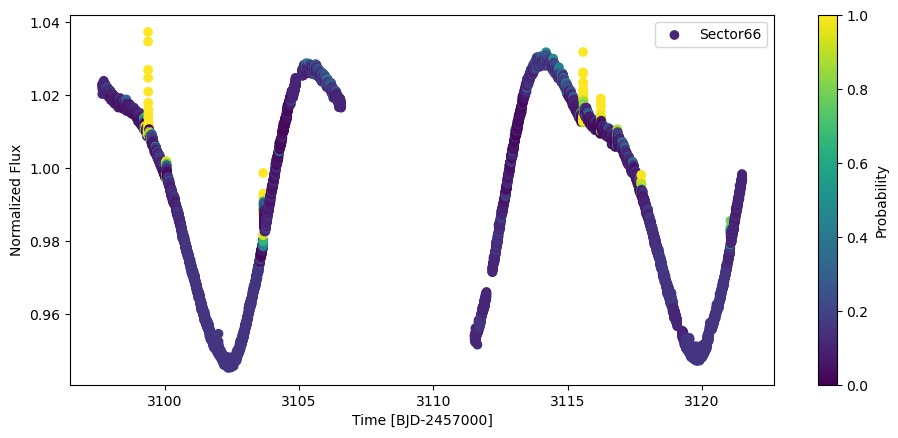

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 3ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

402/402 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


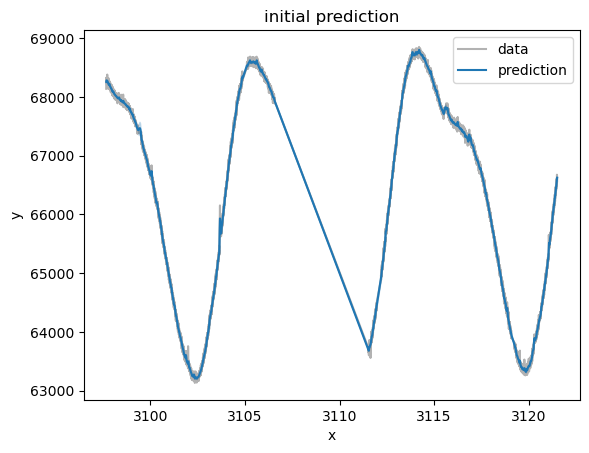

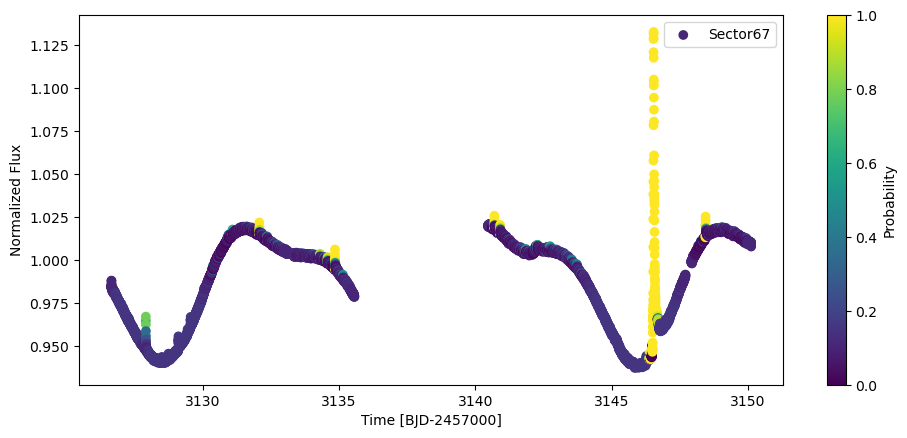

Can only use stella.ConvNN.predict().


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 3s 2ms/step


  0%|                                       | 0/1 [00:00<?, ?it/s]

480/480 [==============================] - 1s 2ms/step


100%|███████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


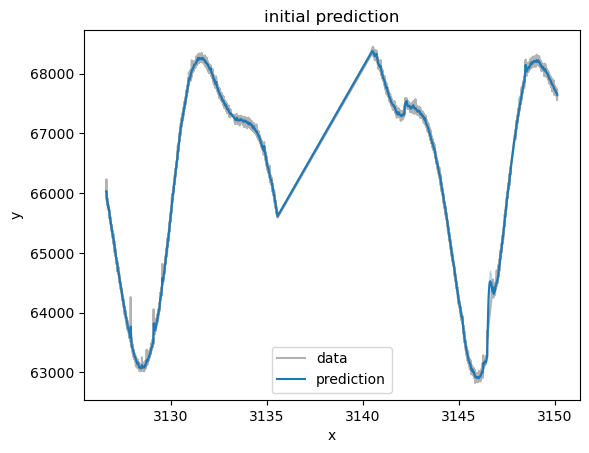

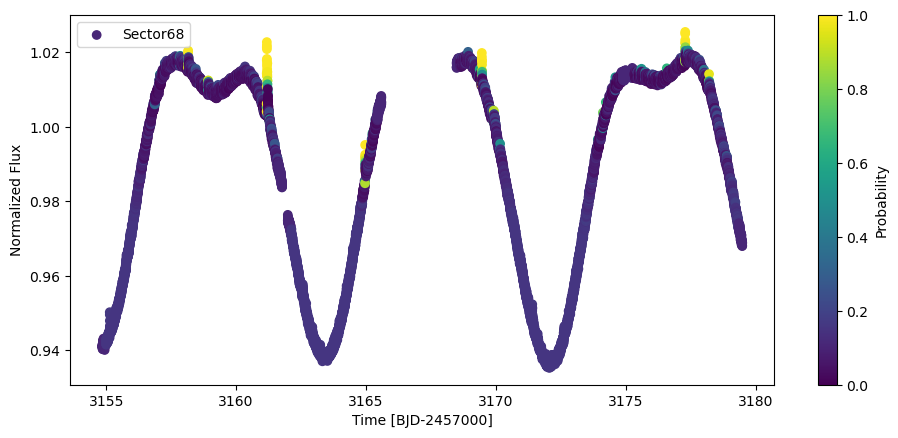

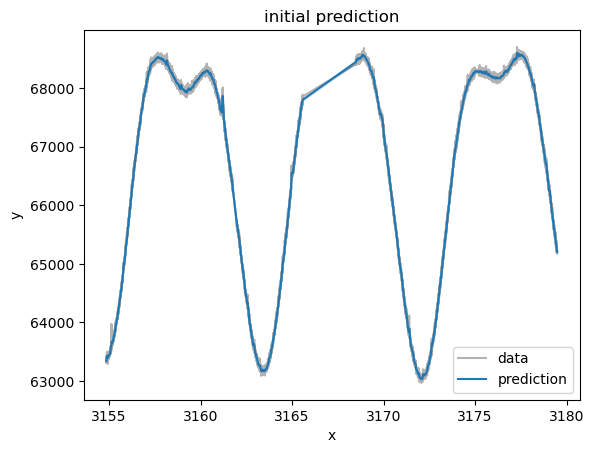

In [34]:
for i in range(16, len(lcs)):
    x, y, xe, ye, flare_starts, flare_stops, EDs = putting_it_all_together(lcs[i])
    
    sector_specific_energies.append(x)
    sector_specific_rates.append(y)
    energy_errors.append(xe)
    rate_errors.append(ye)
    
    flare_starts_list.append(flare_starts)
    flare_stops_list.append(flare_stops)
    EDs_list.append(EDs)

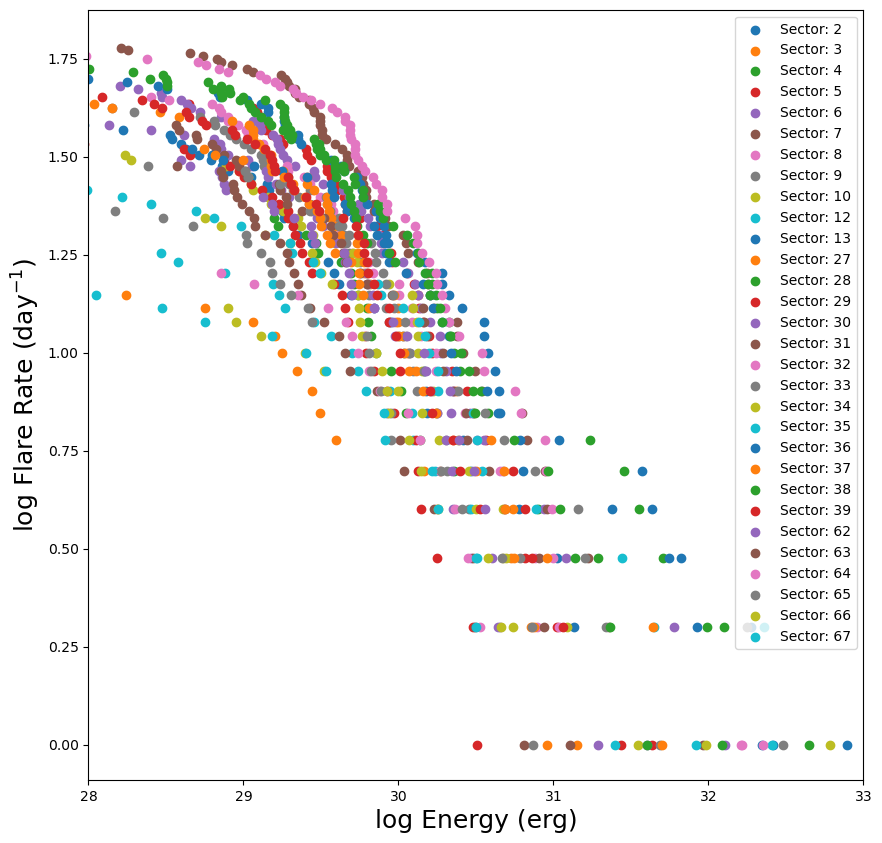

In [43]:
sectors=[int(mission[-2:]) for mission in search.mission]

f=plt.figure(figsize=[10,10])
for i in range(len(sector_specific_energies)):
    
    plt.scatter(sector_specific_energies[i], sector_specific_rates[i], label=('Sector: '+str(sectors[i])))
    #plt.errorbar(sector_specific_energies[i], sector_specific_rates[i], xerr=energy_errors[i], yerr=rate_errors[i])
    plt.xlabel('log Energy (erg)', fontsize=18)
    plt.ylabel('log Flare Rate (day$^{-1}$)', fontsize=18)
    plt.xlim(28,33)
    plt.legend()


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_9403/1929506713.py:6: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.median(lcs[i]['time'].value), np.log10(np.sum(EDs_list[i]*86400) / total_dur),


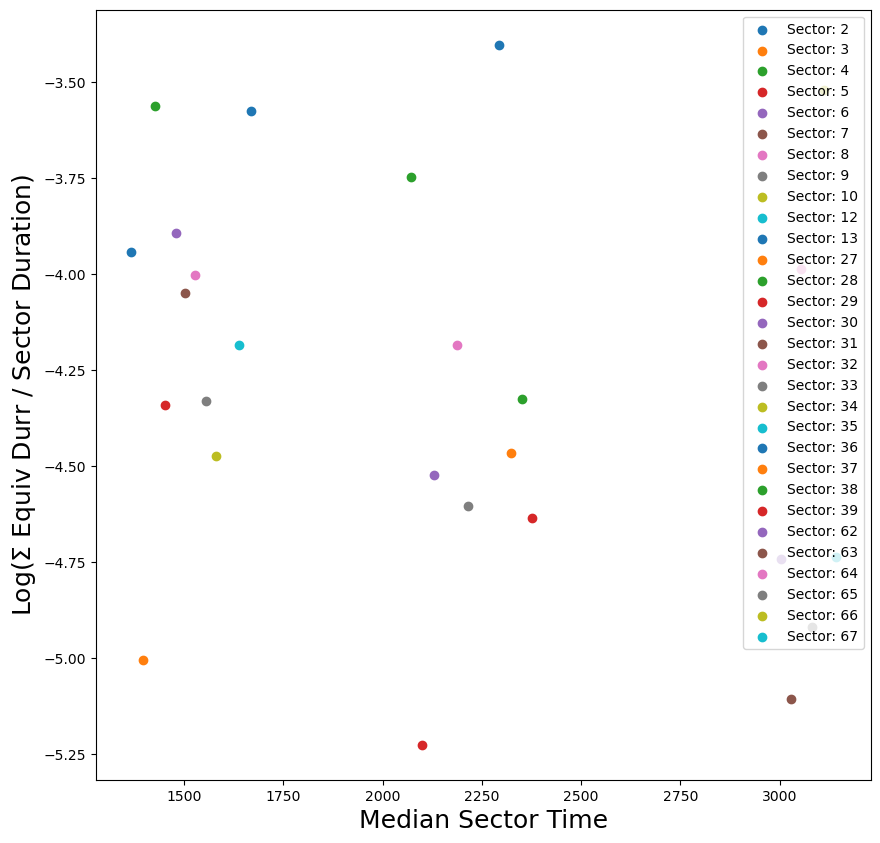

In [45]:
f=plt.figure(figsize=[10,10])
for i in range(len(sector_specific_energies)):
    total_dur=(lcs[i]['time'][-1].value-lcs[i]['time'][0].value)*u.day
    total_dur=(total_dur.to(u.s)).value
    
    plt.scatter(np.median(lcs[i]['time'].value), np.log10(np.sum(EDs_list[i]*86400) / total_dur), 
                                           label=('Sector: '+str(sectors[i])))
                
    plt.ylabel('Log($\Sigma$ Equiv Durr / Sector Duration)', fontsize=18)
    plt.xlabel('Median Sector Time', fontsize=18)
    #plt.xlim(28,33)
    plt.legend()

In [46]:
Dict= {}

Dict["Sector_Energies"] = sector_specific_energies

Dict["Sector_Rates"] = sector_specific_rates

Dict["Energy_Errors"] = energy_errors

Dict["Rate_Errors"] = rate_errors

Dict["Flare_Starts"] = flare_starts_list
Dict["Flare_Stops"] = flare_stops_list
Dict["Equivilant_Durations"] = EDs_list

Dict

{'Sector_Energies': [array([32.34823616, 31.12951994, 31.01961645, 30.7762989 , 30.46621823,
         30.41710861, 30.1847453 , 30.1762171 , 30.16274038, 30.03798546,
         30.03156542, 29.95016276, 29.84149162, 29.69301211, 29.61531371,
         29.58525465, 29.54589425, 29.47433581, 29.44117582, 29.35379888,
         29.32192414, 29.26065337, 29.24903911, 29.19250147, 29.17751461,
         29.16518124, 29.1529959 , 29.04538448, 28.89843689, 28.86453555,
         28.79152663, 28.71448709, 28.62745461, 28.59412959, 28.5403163 ,
         28.52495842, 28.22487839, 27.97275311,         nan,         nan,
                 nan,         nan,         nan,         nan,         nan,
                 nan,         nan]),
  array([31.14902971, 30.85332229, 30.72286836, 30.24544253, 30.16583172,
         29.59377314, 29.49667541, 29.44115018, 29.34219276, 29.24680448,
         29.20561802, 29.0585996 , 28.75329475, 28.24122557,         nan,
                 nan,         nan,         nan,         

In [47]:
import pickle

with open('Energies_and_rates_tic220473309.pkl', 'wb') as f:
    pickle.dump(Dict, f)